### License

Licensed to the Apache Software Foundation (ASF) under one or more
contributor license agreements.  See the NOTICE file distributed with
this work for additional information regarding copyright ownership.
The ASF licenses this file to You under the Apache License, Version 2.0
(the "License"); you may not use this file except in compliance with
the License.  You may obtain a copy of the License at

	  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Imports used in this notebook
Most libraries available through Anaconda 3.8


In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import connections
from elasticsearch_dsl import Search
from elasticsearch_dsl import Q
from elasticsearch_dsl.query import MultiMatch, Match
from collections import Counter, deque
from itertools import count
from uuid import uuid4

import sys
sys.path.append('../')

import datetime
import distill
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import plotly.express as px
import json
import itertools
import os
import networkx as nx
import hashlib, base64
import plotly.graph_objects as go

## Create the Connection,  Define Searches, and Create Generator

In [54]:
flagonClient = connections.create_connection('flagonTest', hosts=['localhost:9200'], timeout=60)
AleS = Search(using='flagonTest', index="userale")
#Filtering raw and custom logs only
qLogType = Q("match", logType="raw") | Q("match", logType="custom")
#defining the user
qUserId = Q("match", userId="nobody")
#Filtering sessionID
qExcludeSession = Q("match", sessionID="session_1671327289682")
#session_1671327289682
#Querying through superset dashboard logs only
qUrl = Q({"wildcard": {
    "pageUrl": {
        "value": "*/superset/dashboard*"
    }
}})

In [55]:
elk_search = AleS \
    .query(qUrl) \
    .query(qLogType) \
    .query(qUserId) \
    .query(qExcludeSession) \
    .extra(track_total_hits=True) #breaks return limit of 10000 hits

In [56]:
ale_dict = {}
elk_response = elk_search.scan()
for hit in elk_response:
    logEntry = (hit.to_dict())
    logEntry['uid'] = distill.getUUID(logEntry)
    logEntry['clientTime'] = distill.epoch_to_datetime(logEntry['clientTime'])
    ctr = len(ale_dict)
    ctr += 1
    ale_dict[ctr] = logEntry
sorted_data = dict(sorted(ale_dict.items(), key = lambda kv: kv[1]['clientTime']))
len(sorted_data)

187

# Filter Dictionaries

Getting a count of how many of the logs included `path`

In [57]:
values = ['path']
sorted_data_paths = {k:v for k, v in sorted_data.items() if any(item in values for item in v.keys())}
len(sorted_data_paths)

187

# Segmentation - Create the Segment object

In [135]:
superSegments = distill.Segments([])


Creating the `deadSpaceSegments`, which are segments that do not include logs

In [136]:
deadSpaceSegments = distill.detect_deadspace(sorted_data_paths, 60, 0, 0)
for counter, d in enumerate(deadSpaceSegments, start=1):
    d.segment_name = str("deadSpace" + str(counter)) #renaming segment names on the fly
    d.segment_length_sec = (d.start_end_val[1] - d.start_end_val[0])/1000 #adding custom segment-object attributes
    print(d.segment_name, d.segment_type, d.start_end_val, d.segment_length_sec, d.num_logs, d.uids)

deadSpace1 Segment_Type.DEADSPACE (1671327545675, 1671327656414) 110.739 2 [42, 71]
deadSpace2 Segment_Type.DEADSPACE (1671327737051, 1671331598676) 3861.625 2 [118, 120]
deadSpace3 Segment_Type.DEADSPACE (1671331599808, 1671369695537) 38095.729 2 [121, 124]
deadSpace4 Segment_Type.DEADSPACE (1671369766609, 1671370107160) 340.551 2 [186, 187]


Creating the `mapSegments`, which are segments that include the world map in their path

In [137]:
mapSegments = distill.generate_segments(sorted_data_paths,'path',['div.superset-legacy-chart-world-map','window'],0,30)
for counter, d in enumerate(mapSegments, start=1): 
    d.segment_name = str("map_" + str(counter))
    d.segment_length_sec = (d.start_end_val[1] - d.start_end_val[0])/1000 #adding custom segment-object attributes
    print(d.segment_name, d.start_end_val, d.segment_length_sec, d.num_logs)
for d in mapSegments:
    if d.num_logs > 20:
        superSegments.append(d)

map_1 (1671327518015, 1671327548015) 30.0 65
map_2 (1671327656414, 1671327686414) 30.0 52
map_3 (1671327737051, 1671327767051) 30.0 1
map_4 (1671331598676, 1671331628676) 30.0 2
map_5 (1671369695537, 1671369725537) 30.0 21
map_6 (1671369733851, 1671369763851) 30.0 38
map_7 (1671369766609, 1671369796609) 30.0 1


Append the `DeadSpaceSegments` and `mapSegments` to `superSegments`

In [138]:
mapSegments_list = []
mapSegment_times = []
for d in mapSegments:
    if d.num_logs > 0:
        mapSegments_list.append(d.segment_name)
        mapSegment_times.append(d.start_end_val)
        
for i in deadSpaceSegments:
    superSegments.append(i)

for d in superSegments:
    print(d.segment_name, d.segment_type)

map_1 Segment_Type.GENERATE
map_2 Segment_Type.GENERATE
map_5 Segment_Type.GENERATE
map_6 Segment_Type.GENERATE
deadSpace1 Segment_Type.DEADSPACE
deadSpace2 Segment_Type.DEADSPACE
deadSpace3 Segment_Type.DEADSPACE
deadSpace4 Segment_Type.DEADSPACE


Filter out segments that have less than 20 logs

In [139]:
mapSegments_data = distill.write_segment(sorted_data_paths, mapSegments_list, mapSegment_times)
for d in mapSegments_data.keys():
    if len(mapSegments_data[d]) > 20:
        print(d, len(mapSegments_data[d]))

map_1 65
map_2 52
map_5 21
map_6 38


## Visualizations

In [140]:
def display_segments(segments):
    """
    Displays a Plotly timeline of Segment objects.

    :param segments: A Segments object containing the Segment objects to display.
    """
    segment_list = []
    for segment in segments:
        if not isinstance(segment.start_end_val[0], datetime.datetime) or not isinstance(segment.start_end_val[1], datetime.datetime):
            new_segment = distill.Segment()
            new_segment.segment_name = segment.segment_name
            new_segment.num_logs = segment.num_logs
            new_segment.uids = segment.uids
            new_segment.generate_field_name = segment.generate_field_name
            new_segment.generate_matched_values = segment.generate_matched_values
            new_segment.segment_type = segment.segment_type
            new_segment.start_end_val = (pd.to_datetime(segment.start_end_val[0], unit='ms', origin='unix'), pd.to_datetime(segment.start_end_val[1], unit='ms', origin='unix'))
            segment_list.append(new_segment)
        else:
            segment_list.append(segment)
    new_segments = distill.Segments(segments=segment_list)
    distill.export_segments("./test.csv",new_segments)
    df = pd.read_csv("./test.csv")
    fig = px.timeline(df, x_start="Start Time", x_end="End Time", y="Segment Name", color="Number of Logs")
    fig.update_yaxes(autorange="reversed")
    os.remove("./test.csv")
    fig.show()

In [119]:
display_segments(superSegments)

Create the edges and nodes for the graphs

In [127]:
edges_map_1 = distill.pairwiseSeq(['|'.join(log['path']) for log in mapSegments_data['map_1'].values()])
edges_list_map_1 = list(edges_map_1)
edges_map_2 = distill.pairwiseSeq(['|'.join(log['path']) for log in mapSegments_data['map_6'].values()])
edges_list_map_2 = list(edges_map_2)

nodes_map_1 = set(['|'.join(log['path']) for log in mapSegments_data['map_1'].values()])
nodes_list_map_1 = list(nodes_map_1)
nodes_map_2 = set(['|'.join(log['path']) for log in mapSegments_data['map_6'].values()])
nodes_list_map_2 = list(nodes_map_2)

G_map1 = distill.createDiGraph(nodes_list_map_1, edges_list_map_1, drop_recursions = False)
G_map2 = distill.createDiGraph(nodes_list_map_2, edges_list_map_2, drop_recursions = False)

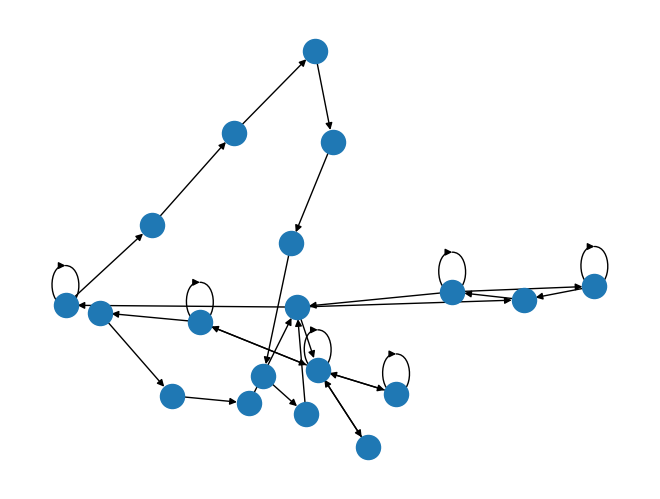

In [142]:
nx.draw(G_map1, with_labels=False)

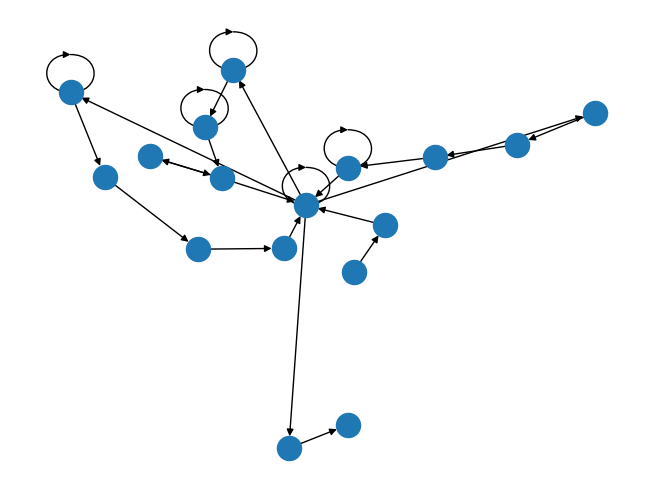

In [128]:
nx.draw(G_map2, with_labels=False)

In [143]:
nx.average_node_connectivity(G_map1)

1.0058479532163742

In [144]:
nx.average_node_connectivity(G_map2)

0.7867647058823529

How many operations are needed to get the two graphs to be identical?

In [146]:
next(nx.optimize_graph_edit_distance(G_map1, G_map2))

42.0